# Auction exercise

We participate in auctions for items characterized by x. In these auctions  each potential buyer must place a single bid, unaware of competitors' bids. The item is awarded to the highest bidder at the price offered. In other words, if we place a bid z and win the auction our costs are equal to z.

The outcomes from the auctions participated are provided in an aggregated format per item. The attached file provides the raw data for a set of auctions participated.

Objectives:
1. Develop a model to predict the probability of winning an auction based on our bid and the item feature x. If you can think of a way, the model should ideally also be able to predict the confidence of predictions.
2. Derive the probability density function for the winning bid for x=3. What is the probability that the winning bid lies between 1 and 2?
3. Let’s assume that we participate again on an identical set of auctions with the same bids as in the provided dataset. Based on your model, what is the probability of observing costs larger than in the provided dataset?

## Imports

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn.metrics as sk_m

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from scipy.stats import gaussian_kde, uniform

In [29]:
random_state = 7
rgn = np.random.default_rng(random_state)

In [30]:
def plot_scores(y_true, y_pred, n_classe:int=2, classe_name=None, modelname='') :
    """
    Arguments :
    Plot the confusion Matrix and different scores
    y_true (array) : Ground truth (correct) target values.
    y_pred (array) :Estimated targets as returned by a classifier.
    """
    N_test = len(y_pred)
    cm = sk_m.confusion_matrix(y_true, y_pred)
    cm_bis = cm.flatten()
    
    if n_classe == 2 :
        group_names = ['True Neg','False Pos','False Neg','True Pos']
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
    else :
        group_counts = [f"{v : 0.0f}" for v in cm_bis]
        group_percentages = ['{0:.2%}'.format(value) for value in cm_bis/N_test]
        for i in range(n_classe**2) :
            if int(group_counts[i]) == 0 :
                group_counts[i], group_percentages[i]= '', ''
        labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(n_classe, n_classe)
    
    if classe_name is None :
        classe_name = list(range(n_classe))
        
    plt.figure(figsize=(9, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=classe_name, yticklabels=classe_name)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(f"Classification report of the model for this testing set")
    print(sk_m.classification_report(y_true, y_pred, digits=3))
    acc_score = sk_m.accuracy_score(y_true, y_pred)
    print('-'*55 + '\n')

## Data preparation

We consider that:
- `x` is the param of the item
- `bid` is the bid we make for this `x`
- `auctions` is the number of auctions we participate with `(x,bid)`
- `wins` is the number of wins we made over `auctions` with `(x,bid)`

In [31]:
df_data = pd.read_csv("auctions_summary.csv", delimiter=',')
df_data["losses"] = df_data["auctions"] - df_data["wins"]
df_data["wins_ratio"] = df_data["wins"] / df_data["auctions"]
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,2.866859,1.581527,5.093069,2.190099,2.902970,0.417230
std,1.747467,1.554054,2.224782,2.727633,2.808097,0.454676
min,0.028227,-1.680578,1.000000,0.000000,-3.000000,0.000000
25%,1.256365,0.384293,3.000000,0.000000,0.000000,0.000000
50%,2.862625,0.944562,5.000000,1.000000,3.000000,0.166667
75%,4.394171,2.421456,6.000000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.500000


We assume that the bid is positive, and that we can't win more time that we've participated auctions for a given `(x,bid)`.  
We remove these inconsistent data from the dataset.

In [32]:
df_data = df_data[(df_data["bid"] >= 0) & (df_data["wins_ratio"] <= 1)]

In [33]:
df_data.describe()

,x,bid,auctions,wins,losses,wins_ratio
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.856842,1.598030,5.098000,2.166000,2.932000,0.411617
std,1.747752,1.546013,2.228526,2.709451,2.796967,0.449939
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000
25%,1.242002,0.392008,3.000000,0.000000,0.000000,0.000000
50%,2.860087,0.958994,5.000000,1.000000,3.000000,0.166667
75%,4.391381,2.433355,6.250000,4.000000,5.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000


## Data visualization

In [34]:
print(f"Ratio of number of auctions win: {df_data['wins'].sum()/df_data['auctions'].sum():.2%}")

Ratio of number of auctions win: 42.49%


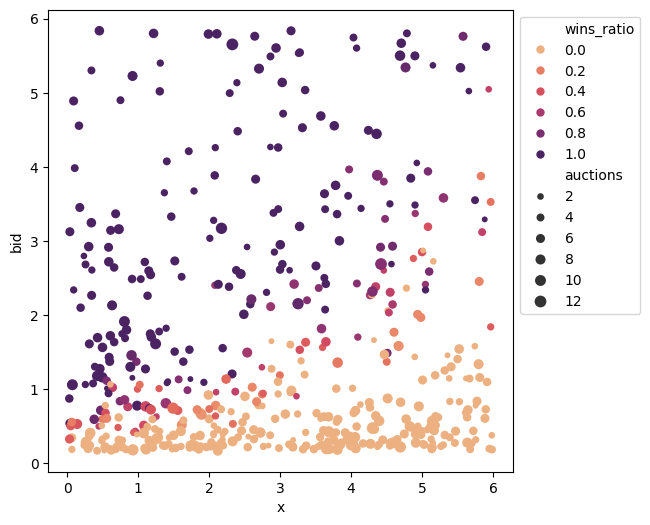

In [35]:
fig, ax = plt.subplots(figsize=(6, 6))
# sns.despine(f, left=True, bottom=True)
sns.scatterplot(
    x="x", y="bid", hue="wins_ratio", size="auctions",
    palette="flare", linewidth=0, data=df_data, ax=ax
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

Data are not well reparted, we don't have a lot with high bid

### Data split

We assume that the result of the auctions are independent from the others. The bids are also independent from each other.

In [36]:
df_data.loc[:, ["win"]] = df_data.loc[:, ["wins", "losses"]].apply(lambda s: [0]*s['losses'] + [1]*s['wins'], axis=1)
df_data_expanded = df_data.explode("win", ignore_index=True)\
    .astype({"win": int})\
    .sample(frac=1)
df_data_expanded.describe()

,x,bid,auctions,wins,losses,wins_ratio,win
count,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000,2549.000000
mean,2.811986,1.614155,6.070224,2.604943,3.465281,0.424872,0.424872
std,1.732706,1.574560,2.226255,3.076802,3.181961,0.451324,0.494421
min,0.028227,0.169887,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.178089,0.407546,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2.807454,0.932589,6.000000,1.000000,3.000000,0.200000,0.000000
75%,4.346854,2.426483,7.000000,5.000000,6.000000,1.000000,1.000000
max,5.984624,5.837404,12.000000,12.000000,12.000000,1.000000,1.000000


### Data distribution

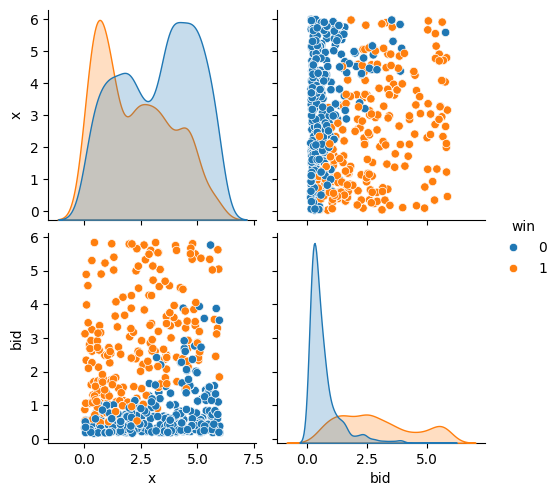

In [37]:
sns.pairplot(
    df_data_expanded, hue="win", vars=("x", "bid")
)

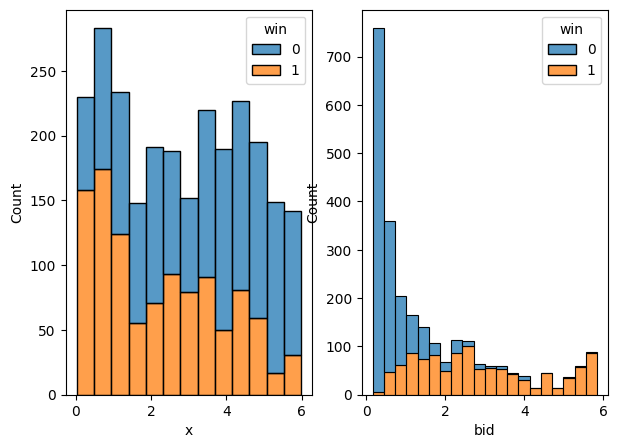

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(7, 5))

sns.histplot(
    df_data_expanded, x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    df_data_expanded, x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
plt.show()

The data are not following a gaussian distribution

## Training and exploration

In [39]:
X = df_data_expanded[["x", "bid"]].to_numpy()
y = df_data_expanded["win"].to_numpy()
n_data = len(y)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

#### Data transformation

In [41]:
from sklearn import preprocessing

Yeo-Johnson or Box-Cox transformation

In [42]:
# pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)
X_train_transform = pt.fit_transform(X_train)
X_val_transform = pt.transform(X_val)
X_test_transform = pt.transform(X_test)
X_transform = pt.transform(X)

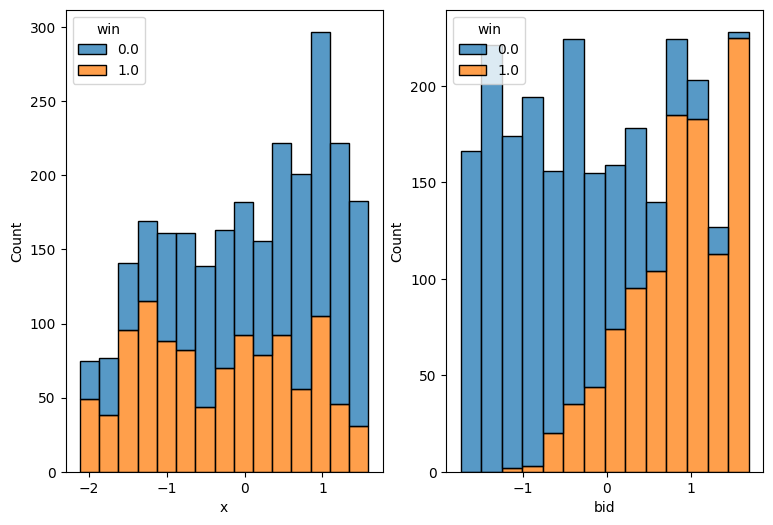

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(9, 6))
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 0, None], y[:, None])),
        columns=("x", "win")
    ), x="x", hue="win",
    multiple="stack", ax=axs[0]
)
sns.histplot(
    pd.DataFrame(
        np.hstack((X_transform[:, 1, None], y[:, None])),
        columns=("bid", "win")
    ), x="bid", hue="win",
    multiple="stack", ax=axs[1]
)
plt.show()

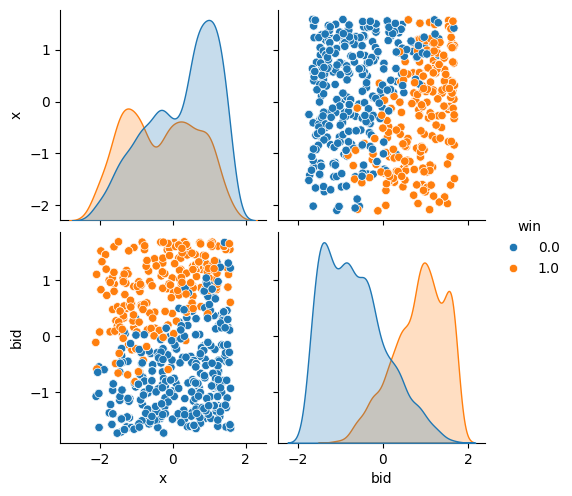

In [44]:
df_data_expanded_trans = pd.DataFrame(
    np.hstack((X_transform, y[:, None])),
    columns=("x", "bid", "win")
)

sns.pairplot(
    df_data_expanded_trans, hue="win", vars=("x", "bid")
)

### Training

In [45]:
early_stopping = lgb.early_stopping(stopping_rounds=10)
kfold = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)

Which model is the best using CV validation and basic training

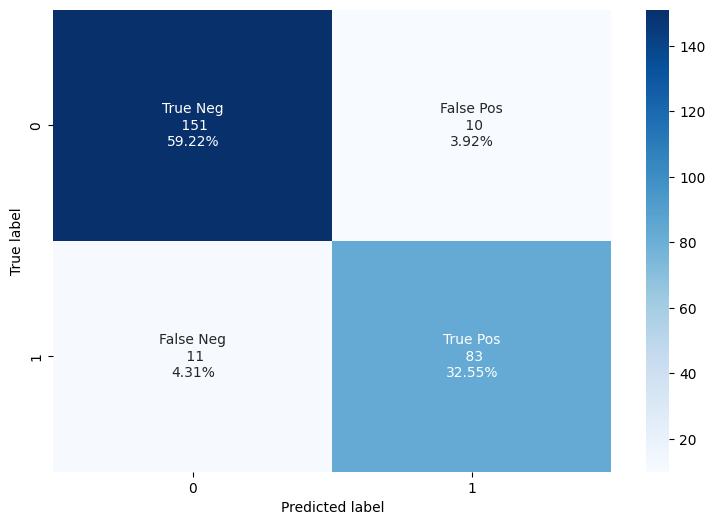

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.932     0.938     0.935       161
           1      0.892     0.883     0.888        94

    accuracy                          0.918       255
   macro avg      0.912     0.910     0.911       255
weighted avg      0.917     0.918     0.918       255

-------------------------------------------------------



In [46]:
# Logistic Regression for classification
from sklearn.linear_model import LogisticRegressionCV

lr_clf = LogisticRegressionCV(cv=10, max_iter=200, random_state=random_state)\
    .fit(X_train_transform, y_train)

y_pred = lr_clf.predict_proba(X_test_transform)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred[:, 1]]))

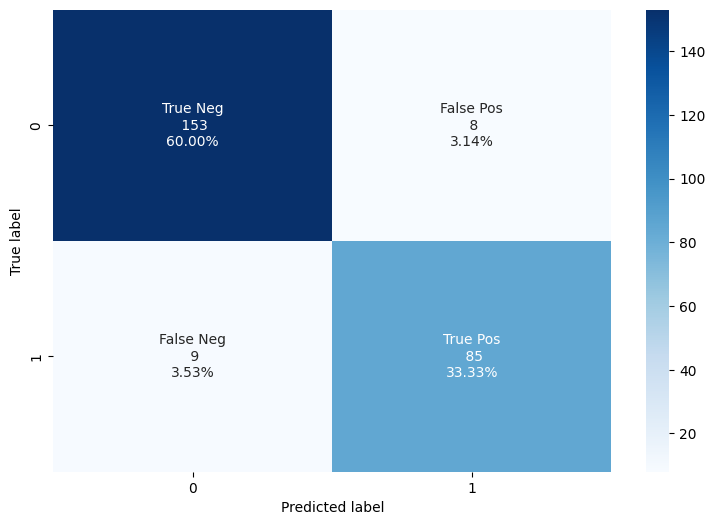

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.944     0.950     0.947       161
           1      0.914     0.904     0.909        94

    accuracy                          0.933       255
   macro avg      0.929     0.927     0.928       255
weighted avg      0.933     0.933     0.933       255

-------------------------------------------------------



In [47]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda_clf = QuadraticDiscriminantAnalysis(store_covariance=True)\
    .fit(X_train_transform, y_train)

y_pred = qda_clf.predict_proba(X_test_transform)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred[:, 1]]))


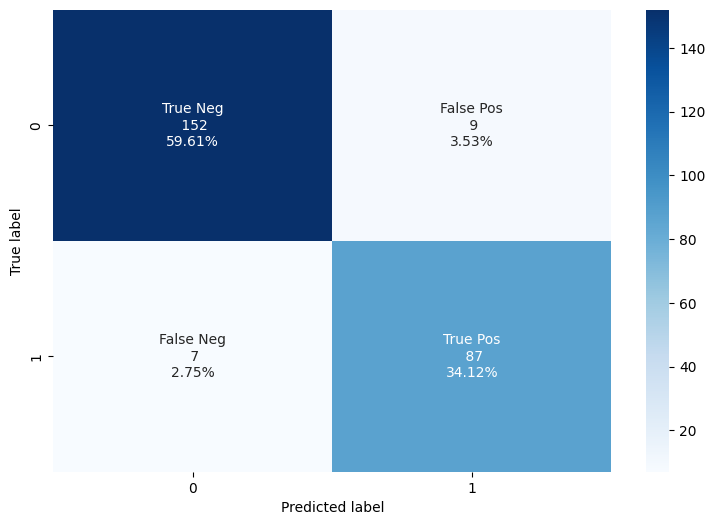

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.956     0.944     0.950       161
           1      0.906     0.926     0.916        94

    accuracy                          0.937       255
   macro avg      0.931     0.935     0.933       255
weighted avg      0.938     0.937     0.937       255

-------------------------------------------------------



In [48]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(early_stopping=True)\
    .fit(X_train_transform, y_train)

y_pred = mlp_clf.predict_proba(X_test_transform)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred[:, 1]]))

In [49]:
# LGBM Classifier with CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_results = cross_val_score(lgbm_clf, X_train, y_train, cv=kfold)
print(f"\nAccuracy: {lgbm_results.mean():.2%} ({lgbm_results.std():.2%})")

[LightGBM] [Info] Number of positive: 797, number of negative: 1038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 491
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434332 -> initscore=-0.264196
[LightGBM] [Info] Start training from score -0.264196
[LightGBM] [Info] Number of positive: 797, number of negative: 1038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 1835, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434332 -> initscore=-0.264196
[LightGBM] [In

[LightGBM] [Info] Number of positive: 886, number of negative: 1153
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 2039, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434527 -> initscore=-0.263406
[LightGBM] [Info] Start training from score -0.263406
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.167729


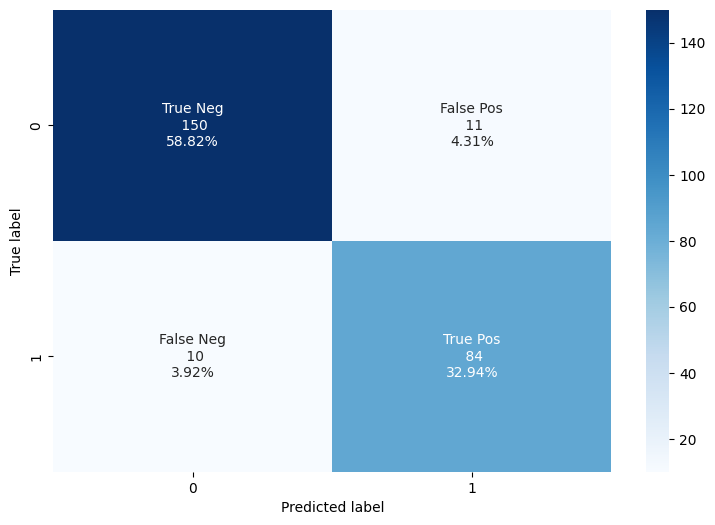

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.938     0.932     0.935       161
           1      0.884     0.894     0.889        94

    accuracy                          0.918       255
   macro avg      0.911     0.913     0.912       255
weighted avg      0.918     0.918     0.918       255

-------------------------------------------------------



In [50]:
# LGBM Classifier without CV
lgbm_clf = lgb.LGBMClassifier(random_state=random_state)
lgbm_clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[early_stopping]
)
y_pred = lgbm_clf.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

In [51]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'metric': 'binary_logloss',
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': None,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': 7,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}

[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 890, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Number of positive: 890, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 490
[LightGBM] [Info] Number of data points in the 

d:\Loan\Documents\Code\exercise_auction\devenv\lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


Early stopping, best iteration is:
[39]	cv_agg's valid binary_logloss: 0.197014 + 0.0204419


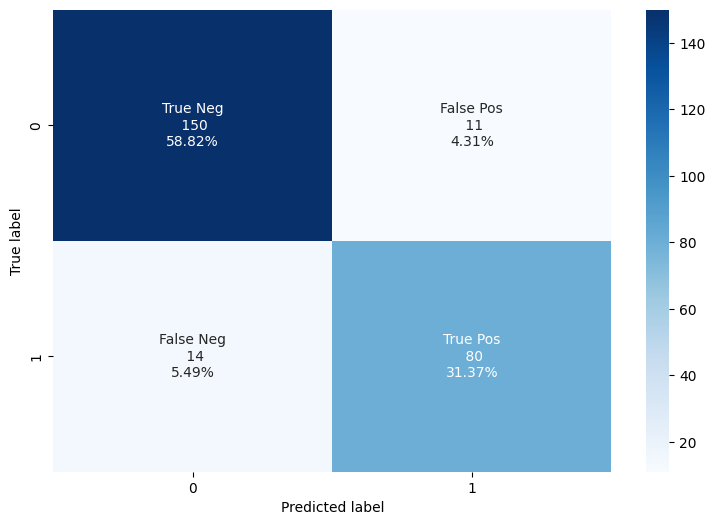

Classification report of the model for this testing set
              precision    recall  f1-score   support

           0      0.915     0.932     0.923       161
           1      0.879     0.851     0.865        94

    accuracy                          0.902       255
   macro avg      0.897     0.891     0.894       255
weighted avg      0.902     0.902     0.902       255

-------------------------------------------------------



In [52]:
lgbm_cv = lgb.cv(
    params,
    lgb.Dataset(np.vstack((X_train, X_val)),np.hstack((y_train, y_val))),
    folds=kfold,
    callbacks=[early_stopping],
    return_cvbooster=True
)
lgbm_clf_cv = lgbm_cv['cvbooster'].boosters[-1]

y_pred = lgbm_clf_cv.predict(X_test)
plot_scores(y_test, np.array([0 if x < 0.5 else 1 for x in y_pred]))

Shoud I use model trained on X_train, or should I use it on the full X

## Probability density function for the winning bids for `x=3`

We look for the probability density function `f(bid,x=3,win=1)`.

We consider that the possible bid are between the minimum and maximum bids that we observed and that we consider consistent. 

In [53]:
N = 15000
bid_min, bid_max = X[:, 1].min(), X[:, 1].max()
# We simulate N auctions, with bids following an uniform random variable, between the min and max bids in the known data
z = uniform.rvs(loc=bid_min, scale=bid_max, size=(N, 1), random_state=random_state)
X_density3 = np.hstack((np.full((N, 1), 3), z))
# We apply box-cox transform to simulated data to predict auctions results based on our model
X_density3_transform = pt.transform(X_density3)
y_density3 = lr_clf.predict(X_density3_transform)

[]

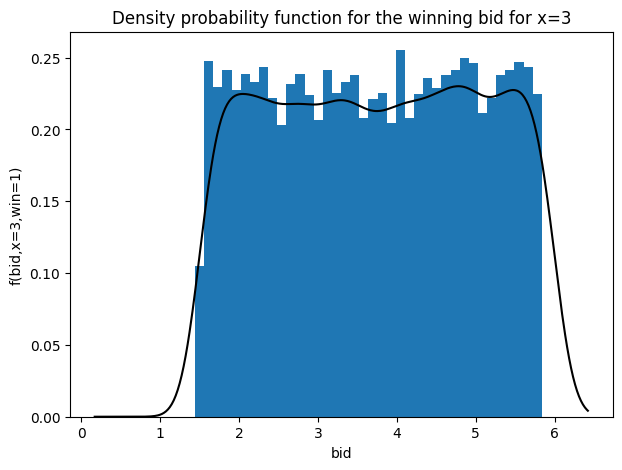

In [56]:
# We fit a gaussian kde on the input bids that have probability of winning > 0.5
density = gaussian_kde(X_density3[y_density3.astype(bool)][:, 1])
u = np.linspace(bid_min, 1.1*bid_max, 500)
v = density.evaluate(u)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(u, v, 'k')
ax.set_xlabel("bid")
ax.set_ylabel("f(bid,x=3,win=1)")
ax.set_title("Density probability function for the winning bid for x=3")

ax.hist(
    X_density3[y_density3.astype(bool)][:, 1],
    bins=np.linspace(bid_min, bid_max, 50),
    density=True)
plt.plot()

Variable aléatoire prend des valeurs les mises pour des enchères gagnées avec x=3.

In [55]:
print(f"P(1 <= bid <= 2 | x=3,  win=1) \u2248 {density.integrate_box_1d(1, 2):.3%}")

P(1 <= bid <= 2 | x=3,  win=1) ≈ 11.306%


## Cost computation

In [59]:
real_cost = np.sum(X[:, 1] * y)

We do a Monte Carlo simulation with `n_simulations` auctions sets, using our model to probabilities to get samples of won auctions associated to known `(x,bid)`.
We then compute the costs for each sample, and compute how many of them are higher than the real cost.

The probability of having a higher cost is obtained using the law of the large numbers.

In [62]:
n_simulations = 20000
y_pred_proba = lr_clf.predict_proba(X_transform)
samples = rgn.binomial(1, y_pred_proba[:,1], (n_simulations, n_data)).T
expected_cost_samples = np.sum(X[:, 1, None] * samples, axis=0)

In [63]:
proba_higher_cost = (expected_cost_samples >= real_cost).sum()
print(f"P(pred_costs >= real_costs) \u2248 {proba_higher_cost/n_simulations:.3%}")

P(pred_costs >= real_costs) ≈ 63.330%


In [67]:
real_cost

3117.069459996044

[]

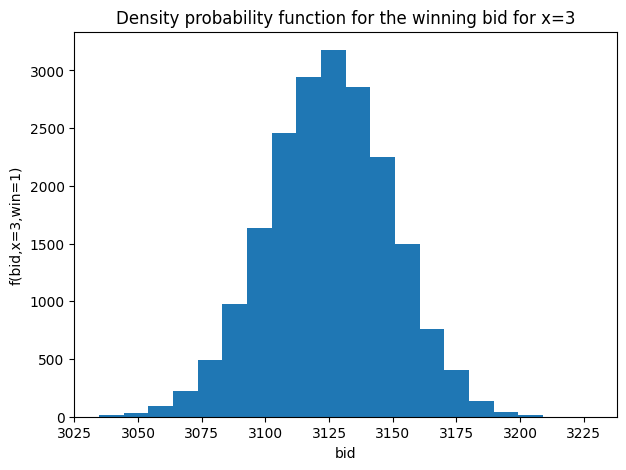

In [68]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("bid")
ax.set_ylabel("f(bid,x=3,win=1)")
ax.set_title("Density probability function for the winning bid for x=3")

ax.hist(
    expected_cost_samples,
    bins=20)
plt.plot()

Outliers sont vérifiées, bonne interprétation de les virer
Questionner les outliers, avoir des explications sur les variables est intéressant
Ne pas négliger l'aspect descriptif (nombre d'observations, distribution des variables, `étudier la corrélation entre les variables` (si elles sont corrélées ça peut fausser les explications))
Bien dire que je ne prends pas en compte le nombre d'enchères réalisées pour un set (x, bid)
Vérification des hypothèses (regression logistique, hypothèses sur les résidus)
Vérifier les limites du modèle en lui même (interprétation), quelle variable influe le plus, significativité
Voir les limites des métriques utilisées (utiliser la courbe ROC ?)

Limite de la question des couts supérieurs ou inférieurs
Pas de quantification de à quel point je suis au dessus en dessous des couts réels. Quantification de dans le pire des cas
Proba à relier aux gains

Cohérence des travaux